# Práctica 4: Procesamiento del Lenguaje Natural

__Fecha de entrega: 14 de mayo de 2024__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

# 1) Carga del conjunto de datos

El fichero `spam.csv` contiene mensajes SMS etiquetados como spam or ham (legítimo).

Muestra un ejemplo de cada clase.

Haz un estudio del conjunto de datos. ¿qué palabras aparecen más veces?, ¿tendría sentido normalizar de alguna manera el corpus?

Crea una partición de los datos dejando el 60% para entrenamiento, 20% para validación y el 20% restante para test. Comprueba que la distribución de los ejemplos en las particiones es similar.

In [1]:
RANDOM_STATE = 1234

In [2]:
# acceso a google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [53]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
df1 = pd.read_csv('/content/drive/MyDrive/spam.csv', encoding="cp1252")
df1

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


Ahora eliminamos las columnas con valores nulos.

In [55]:
#df_1 = df1[df1.iloc[:, 2].isna()]
#df_1 = df_1[df_1.iloc[:, 3].isna()]
#df_1 = df_1[df_1.iloc[:, 4].isna()]
'''
for indice_fila, fila in df_filtrado.iterrows():
     palabra = fila.iloc[3]  # Acceder al valor en la tercera columna de cada fila
     if not pd.isna(palabra):  # Verificar si el valor no es NaN
        print(palabra)
'''

df1 = df1.iloc[:, :2]
df1 = df1.dropna()
df1

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [56]:
for clase in df1['v1'].unique():
 if not pd.isna(clase):
      # Obtener el primer elemento de cada clase
      primer_elemento = df1[df1['v1'] == clase].iloc[0]
      # Agregarlo al diccionario
      print(primer_elemento)

v1                                                  ham
v2    Go until jurong point, crazy.. Available only ...
Name: 0, dtype: object
v1                                                 spam
v2    Free entry in 2 a wkly comp to win FA Cup fina...
Name: 2, dtype: object


In [57]:
print(df1['v1'].value_counts())

v1
ham     4825
spam     747
Name: count, dtype: int64


Vemos que la cantidad de mensajes del tipo *ham* aparece mucho más que el tipo *spam* lo que indica que el *dataset* no esta balanceado. Por tanto, a la hora de sacar conclusiones tendremos que tener en mente este hecho, ya que podría suceder que no fueran todo lo representativas que quisiéramos.

A continuación normalizaremos el documento eliminando caracteres especiales, pasando a minúsculas y eliminando palabras vacías.

In [58]:
wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [71]:
from sklearn.feature_extraction.text import CountVectorizer

# Normalizamos los datos
datos_normalizados = normalize_corpus(df1['v2'].values)

cv = CountVectorizer()
cv_matrix = cv.fit_transform(datos_normalizados)
cv_matrix = cv_matrix.toarray()
suma_columnas = cv_matrix.sum(axis = 0)
indice_columna_maxima = np.argmax(suma_columnas)

nombres_columnas = cv.get_feature_names_out()

print(f"La palabra más repetida es '{nombres_columnas[indice_columna_maxima]}'.")
print(f"Se repite un total de {np.max(suma_columnas)} veces.")

La palabra más repetida es 'call'.
Se repite un total de 579 veces.


Creamos ahora la partición del dataset.

In [84]:
# Aplicamos la normalización de los datos sobre el dataset
df1['v2'] = df1['v2'].apply(lambda x: normalize_corpus(x))

from sklearn.model_selection import train_test_split

# Creamos una partición temporal del 40%
train_df, temp_df = train_test_split(df1, test_size=0.4, random_state=RANDOM_STATE)

# Del 40% temporal, 50% a test y 50% a validación
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_STATE)

# 2) Representación como bolsa de palabras

Elige justificadamente una representación de bolsa de palabras y aplícala.
Muestra un ejemplo antes y después de aplicar la representación. Explica los cambios.

Debido a que las palabras que se encuentran en el corpus pueden o no estar en un diccionario habitual (ya que utilizan una «jerga» de los SMS en la que las palabras se acortan) y no aparecen demasiadas palabras "raras" (números sueltos y demás símbolos), nos hemos decantado por usar el diccionario inferido por el conjunto de entrenamiento. Para eliminar las palabras con poco valor diferenciador, aplicaremos una transformación TF-IDF.

In [103]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.

    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0

    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))

    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index])

    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [104]:
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = CountVectorizer(stop_words='english')

# Tomamos los textos del conjunto de entrenamiento y los transformamos en
# una matriz de datos (palabras) según el diccionario estándar
train_vector_data = vectorizer.fit_transform(train_df['v2'])

# Sacamos las palabras asociadas a los vectores
feature_names = vectorizer.get_feature_names_out()

tfidfer = TfidfTransformer()
train_preprocessed = tfidfer.fit_transform(train_vector_data)

In [108]:
write_terms(feature_names, train_df['v2'].values, train_preprocessed, 10)

Mensaje 10 : premium phone services call
Mensaje 10 vectorizado: ['phone' 'premium' 'services'] 



Los datos que hemos usado para entrenar el `CountVectorizer` y el `TfidfTransformer` son los de entrenamiento que hemos sacado al hacer las particiones.

El ejemplo de mensaje que hemos puesto (el 100 de entre los de entrenamiento) muestra la diferencia entre el original y el vector de la bolsa de palabras que surge de él. Podemos apreciar que el vector no tiene palabras repetidas y palabras muy comunes como *u* han sido ignoradas.

Ahora aplicamos las transformaciones sobre los datos de test y validación.

In [106]:
# Test
test_vector_data = vectorizer.transform(test_df['v2'])
test_preprocessed = tfidfer.transform(test_vector_data)

# Validación
val_vector_data = vectorizer.transform(val_df['v2'])
val_preprocessed = tfidfer.transform(val_vector_data)

# 3) Aplica 3 algoritmos de aprendizaje automático para resolver la tarea

Justifica porqué los has elegido.
Ajusta los modelos respecto a un hiperparámetro que consideres oportuno. Justifica tu elección.
Explica los resultados obtenidos.

## Árbol de decisión
Como en la anterior práctica usaremos árboles de decisión. El hiperparámetro que optimizaremos será, de nuevo, la profundidad máxima.

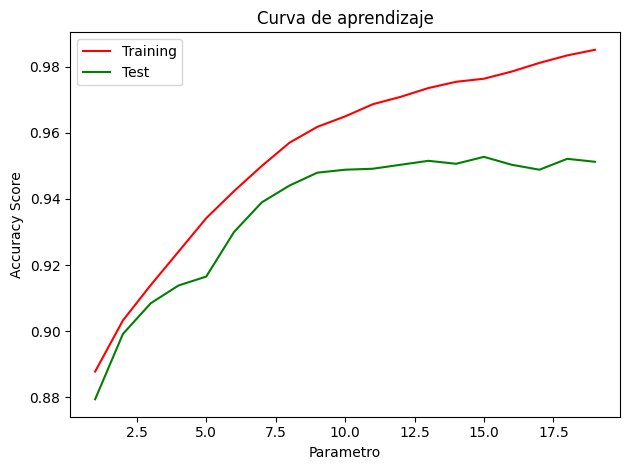

In [125]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

train_accuracy = []
test_accuracy = []

# Entrenamos y validamos varios árboles con distintas profundidades máximas
max_depths = range(1, 20)
for md in max_depths:
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=md, min_samples_split=2, random_state=RANDOM_STATE)
    scores = cross_validate(clf, train_preprocessed, train_df['v1'].values, scoring='accuracy', cv=10, return_train_score=True)

    train_accuracy.append(np.mean(scores['train_score']))
    test_accuracy.append(np.mean(scores['test_score']))


# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Como podemos apreciar a partir del valor `10` el algoritmo comienza a tener overfitting y los resultados del test no mejoran por lo que usaremos ese valor.

In [123]:
tree_classifier = DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_split=2, random_state=RANDOM_STATE)
tree_classifier.fit(train_preprocessed, train_df['v1'].values)

tree_train_predictions = tree_classifier.predict(train_preprocessed)
tree_test_predictions = tree_classifier.predict(test_preprocessed)

print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions == train_df['v1'].values))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions == test_df['v1'].values))

Árbol, porcentaje de aciertos en entrenamiento: 0.9661980257253964
Árbol, porcentaje de aciertos en test: 0.9372197309417041


Podemos apreciar que este algoritmo con esta profundidad aporta un alto porcentaje de aciertos (93%) incluso en un *dataset* sobre el que no ha sido entrenado.

## K-NN
Como en la anterior práctica usaremos `k` vecinos más cercanos. El hiperparámetro que optimizaremos será, de nuevo, el número de vecinos.
Ya adelantamos que este algoritmo no es la mejor opción debido a que sufre la «maldición de la dimensionalidad» que en esta clase de problemas es muy acusada (muchas dimensiones y matrices muy dispersas) lo que causará que el algoritmo tenga un rendimiento muy pobre.

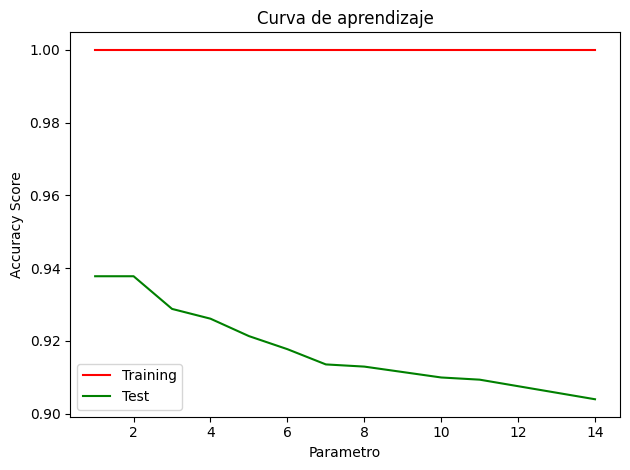

In [129]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

train_accuracy = []
test_accuracy = []

# Entrenamos y validamos varios algoritmos con distinto número de vecinos
num_vec = range(1, 15)
for nv in num_vec:
    clf = KNeighborsClassifier(n_neighbors=nv, weights='distance')
    scores = cross_validate(clf, train_preprocessed, train_df['v1'].values, scoring='accuracy', cv=10, return_train_score=True)

    train_accuracy.append(np.mean(scores['train_score']))
    test_accuracy.append(np.mean(scores['test_score']))


# Draw lines
plt.plot(num_vec, train_accuracy, color="r",  label="Training")
plt.plot(num_vec, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Como podemos apreciar este algoritmo sobreaprende con un valor del hiperparámetro muy bajo, `2`.

In [130]:
knn_classifier = KNeighborsClassifier(n_neighbors=2, weights='distance')
knn_classifier.fit(train_preprocessed, train_df['v1'].values)

knn_train_predictions = knn_classifier.predict(train_preprocessed)
knn_test_predictions = knn_classifier.predict(test_preprocessed)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions == train_df['v1'].values))
print("k-NN, porcentaje de aciertos en test:", np.mean(knn_test_predictions == test_df['v1'].values))

k-NN, porcentaje de aciertos en entrenamiento: 1.0
k-NN, porcentaje de aciertos en test: 0.947085201793722


A pesar de todo, este algoritmo sigue aportando un resultado más que aceptable.

## Naive Bayes
Como clasificador *Naive Bayes* usaremos el **Bernoulli** ya que es el más apto para clasificar documentos cortos y detectar contenido muy específico (como es en este caso ser o no *spam*). Ya que los datos que surgen de aplicar TF-IDF son continuos y este algoritmo necesita valores binarios, usaremos como hiperpárametro el *threshold* a partir del cuál se «binariza» un valor.

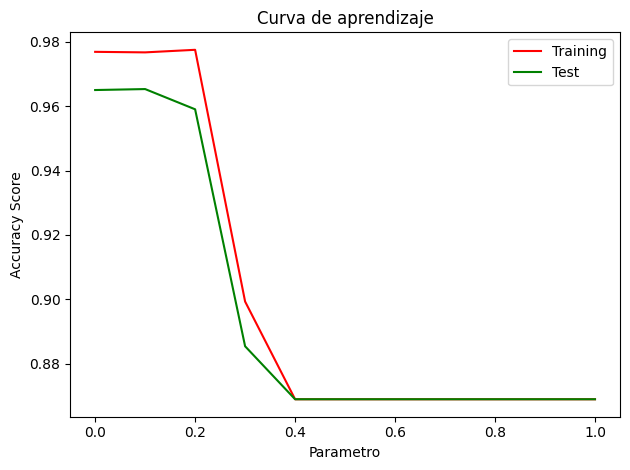

In [134]:
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

train_accuracy = []
test_accuracy = []

# Entrenamos y validamos varios thresholds
thres = [x / 10 for x in range(0, 11)]
for th in thres:
    clf = BernoulliNB(binarize=th)
    scores = cross_validate(clf, train_preprocessed, train_df['v1'].values, scoring='accuracy', cv=10, return_train_score=True)

    train_accuracy.append(np.mean(scores['train_score']))
    test_accuracy.append(np.mean(scores['test_score']))


# Draw lines
plt.plot(thres, train_accuracy, color="r",  label="Training")
plt.plot(thres, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Claramente, un valor bajo, `0.2`, es la mejor opción en este caso.

In [135]:
bnb_classifier = BernoulliNB(binarize=0.2)

bnb_classifier.fit(train_preprocessed, train_df['v1'].values)

bnb_train_predictions = bnb_classifier.predict(train_preprocessed)
bnb_test_predictions = bnb_classifier.predict(test_preprocessed)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(bnb_train_predictions == train_df['v1'].values))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(bnb_test_predictions == test_df['v1'].values))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9814537840263237
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.9614349775784753


Este algoritmo aporta los mejores resultados sobre las métricas que comparamos teniendo un coste computacional sustancialmente menor.

# 4) Construye redes neuronales con Keras con distintas maneras de usar word embeddings

Justifica tus decisiones y explica los resultados obtenidos.

A continuación, veremos distintas formas de usar word embeddings:

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

max_words = 1500
max_comment_length = 20



df1['v1'] = df1['v1'].replace({'ham': 1, 'spam': 0})


tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df1.v2)

sequences = tokenizer.texts_to_sequences(df1.v2)

word_index = tokenizer.word_index
print('Se han encontrado %s tokens únicos.' % len(word_index))
max_words = len(word_index)

data = pad_sequences(sequences, maxlen=max_comment_length)

Se han encontrado 8916 tokens únicos.


In [ ]:
print(df1.v2[4])
print(data[4])
print(df1.v1[4])

Nah I don't think he goes to usf, he lives around here though
[   0    0    0    0    0    0    0    0 1017    1   98  107   69  487
    2  955   69  219  111  471]
1


In [ ]:
from sklearn.model_selection import train_test_split

#valor de random state
rs=333

df1['v1'].replace({'ham': 1, 'spam': 0})
d=df1.values

x_train, x_test, y_train, y_test = train_test_split(data, df1.v1, test_size=0.20, random_state=rs, stratify = df1.v1)

print("Textos de entrenamiento:", len(y_train))
print("Testear textos:", len(y_test))

Textos de entrenamiento: 4457
Testear textos: 1115


In [ ]:
# Fijamos el tamaño de los embedding a 50 dimensiones

embedding_dim = 50

###MODELO 1

En primer lugar, veamos como se comporta sin embeddings pre-entrenados.

In [ ]:
# MODELO 1. SIN EMBEDDINGS PRE-ENTRENADOS

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model1 = Sequential()

model1.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))

model1.add(Flatten())

# Añadimos el clasificador
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

history = model1.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_test, y_test))

score1 = model1.evaluate(x_test, y_test)

print("Precisión: %.2f%%" % (score1[1]*100))

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 20, 50)            445800    
                                                                 
 flatten_17 (Flatten)        (None, 1000)              0         
                                                                 
 dense_17 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 446801 (1.70 MB)
Trainable params: 446801 (1.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
140/140 [==============================] - 2s 8ms/step - loss: 0.3118 - accuracy: 0.9177 - val_loss: 0.1590 - val_accuracy: 0.9578
Epoch 2/20
140/140 [==============================] - 1s 7ms/step - loss: 0.0990 - accuracy: 0.9733 - val_loss: 0.0727 - val_accuracy: 0.98

Como podemos observar, utilizando una capa de embedding la precisión es del 98.74 %.

#### EMBEDDINGS PRE-ENTRENADOS

Ahora utilizaremos un embeddings pre-entrenados. Para ellos, haremos uso del word embedding GloVe

In [ ]:
import os
import numpy as np

glove_dir = '/content/drive/MyDrive/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se han encontrado %s vectores de palabras.' % len(embeddings_index))

Se han encontrado 0 vectores de palabras.


In [ ]:
embedding_dim = 50

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # La palabras no encontradas serán 0.
            embedding_matrix[i] = embedding_vector

### MODELO 2

#### Definimos un modelo

Usaremos la misma arquitectura de modelo que antes:

In [ ]:
# MODELO 2. EMBEDDINGS PRE-ENTRENADOS CONGELADOS

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 20, 50)            445800    
                                                                 
 flatten_18 (Flatten)        (None, 1000)              0         
                                                                 
 dense_18 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 446801 (1.70 MB)
Trainable params: 446801 (1.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


La capa de Embedding tiene una sola matriz de pesos, una matriz bidimensional donde cada entrada i es el vector de palabras asociadas al índice i. Procedamos a cargar dicha matriz:

In [ ]:
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

#### Entrenar y evaluar

Compilemos nuestro modelo y evaluémoslo.

In [ ]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model2.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_test, y_test))

score2 = model2.evaluate(x_test, y_test)
print("Precisión: %.2f%%" % (score2[1]*100))

Epoch 1/20
140/140 [==============================] - 1s 4ms/step - loss: 0.6692 - accuracy: 0.8609 - val_loss: 0.6457 - val_accuracy: 0.8664
Epoch 2/20
140/140 [==============================] - 0s 2ms/step - loss: 0.6251 - accuracy: 0.8658 - val_loss: 0.6047 - val_accuracy: 0.8664
Epoch 3/20
140/140 [==============================] - 0s 3ms/step - loss: 0.5872 - accuracy: 0.8658 - val_loss: 0.5698 - val_accuracy: 0.8664
Epoch 4/20
140/140 [==============================] - 0s 3ms/step - loss: 0.5549 - accuracy: 0.8658 - val_loss: 0.5400 - val_accuracy: 0.8664
Epoch 5/20
140/140 [==============================] - 0s 3ms/step - loss: 0.5275 - accuracy: 0.8658 - val_loss: 0.5147 - val_accuracy: 0.8664
Epoch 6/20
140/140 [==============================] - 0s 4ms/step - loss: 0.5042 - accuracy: 0.8658 - val_loss: 0.4934 - val_accuracy: 0.8664
Epoch 7/20
140/140 [==============================] - 1s 4ms/step - loss: 0.4847 - accuracy: 0.8658 - val_loss: 0.4755 - val_accuracy: 0.8664
Epoch 

Obtenemos un 86,64 % de precisión con el modelo pre-procesado congelado.

### MODELO 3

También podemos entrenar el mismo modelo sin congelar la capa de embedding.

In [ ]:
# MODELO3. EMBEDDINGS PREENTRENADOS SIN CONGELAR

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model3 = Sequential()
model3.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
model3.add(Flatten())
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = True

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model3.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_test, y_test))

score3 = model3.evaluate(x_test, y_test)
print("Precisión: %.2f%%" % (score3[1]*100))

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 20, 50)            445800    
                                                                 
 flatten_19 (Flatten)        (None, 1000)              0         
                                                                 
 dense_19 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 446801 (1.70 MB)
Trainable params: 446801 (1.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
140/140 [==============================] - 2s 8ms/step - loss: 0.2906 - accuracy: 0.9242 - val_loss: 0.1145 - val_accuracy: 0.9641
Epoch 2/20
140/140 [==============================] - 1s 7ms/step - loss: 0.0733 - accuracy: 0.9796 - val_loss: 0.0594 - val_accuracy: 0.98

En este caso, con el modelo pre-procesado sin congelar obtenemos un 98.74 % de precisión.

### RESUMEN DE LOS RESULTADOS

In [ ]:
print("Sin word embeddings pre-entrenados")
print("Precisión: %.2f%%" % (score1[1]*100))
print("Con word embeddings pre-entrenados congelados")
print("Precisión: %.2f%%" % (score2[1]*100))
print("Con word embeddings pre-entrenados sin congelar")
print("Precisión: %.2f%%" % (score3[1]*100))

Sin word embeddings pre-entrenados
Precisión: 98.92%
Con word embeddings pre-entrenados congelados
Precisión: 86.64%
Con word embeddings pre-entrenados sin congelar
Precisión: 98.74%


# 5) Aplica los modelos construidos a los datos de test y compáralos.

Calcula las métricas de recall, precisión y f1.
Discute cual es el mejor modelo y cual es peor y porqué.



En un problema de clasificación multiclase suele ser muy interesante analizar el rendimiento de la clasificación en cada una de las clases

Esto nos permite analizar en qué clases funciona mejor o peor el clasificador, de acuerdo a métricas como la precisión (cuando predice dicha clase cuánto acierta) y la exhaustividad  (cuántos ejemplos de una clase predice correctamente). También podemos ver la media (armònica) entre ambas medidas (F1 score).


---



### NAIVE BAYES

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = mnb_test_predictions
print(classification_report(test_data.target, predictions, target_names=test_data.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.83      0.44      0.57       319
           comp.graphics       0.66      0.69      0.67       389
 comp.os.ms-windows.misc       0.65      0.63      0.64       394
comp.sys.ibm.pc.hardware       0.55      0.72      0.63       392
   comp.sys.mac.hardware       0.73      0.59      0.65       385
          comp.windows.x       0.75      0.74      0.75       395
            misc.forsale       0.88      0.72      0.79       390
               rec.autos       0.87      0.86      0.86       396
         rec.motorcycles       0.88      0.87      0.87       398
      rec.sport.baseball       0.93      0.88      0.91       397
        rec.sport.hockey       0.91      0.95      0.93       399
               sci.crypt       0.66      0.95      0.78       396
         sci.electronics       0.76      0.63      0.69       393
                 sci.med       0.92      0.81      0.86       396
         

(En el caso del Naive Bayes Multinomial hay clases que se clasifican muy bien, como `rec.sport.hockey`, `rec.sport.baseball` y `rec.motorcycles`.

Sin embargo, es interesante que hay clases como `talk.religion.misc` con una precisión muy alta y una exhaustividad muy bajo, y por otro lado clases donde sucede lo contrario, aunque no tan acusado, como en `soc.religion.christian`.

La exhaustividad muy baja indica que esos textos tienden a confundirse mucho con otros. Una precisión baja por el contrario quiere decir que el clasificador no ha sido capaz de encontrar rasgos distintivos para dichos textos que los diferencien de otros.)


### K-MEANS

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = kmeans_test_predictions
print(classification_report(test_data.target, predictions, target_names=test_data.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.83      0.44      0.57       319
           comp.graphics       0.66      0.69      0.67       389
 comp.os.ms-windows.misc       0.65      0.63      0.64       394
comp.sys.ibm.pc.hardware       0.55      0.72      0.63       392
   comp.sys.mac.hardware       0.73      0.59      0.65       385
          comp.windows.x       0.75      0.74      0.75       395
            misc.forsale       0.88      0.72      0.79       390
               rec.autos       0.87      0.86      0.86       396
         rec.motorcycles       0.88      0.87      0.87       398
      rec.sport.baseball       0.93      0.88      0.91       397
        rec.sport.hockey       0.91      0.95      0.93       399
               sci.crypt       0.66      0.95      0.78       396
         sci.electronics       0.76      0.63      0.69       393
                 sci.med       0.92      0.81      0.86       396
         

### ÁRBOLES DE DECISIÓN

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = arbol_test_predictions
print(classification_report(test_data.target, predictions, target_names=test_data.target_names))